In [1]:
import os
import time
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Read dataset

In [22]:
def load_data(data_dir):
    # 3 types: COVID, Non-Covid, Normal 
    classes = os.listdir(data_dir)
    images = []
    lung_masks = []
    infection_masks = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_subdir = os.path.join(class_dir, 'images')
            lung_mask_subdir = os.path.join(class_dir, 'lung masks')
            infection_mask_subdir = os.path.join(class_dir, 'infection masks')

            for filename in os.listdir(image_subdir):
                if filename.endswith(".png"):
                    # Load image
                    image_path = os.path.join(image_subdir, filename)
                    lung_mask_path = os.path.join(lung_mask_subdir, filename)
                    infection_mask_path = os.path.join(infection_mask_subdir, filename)
                    if not os.path.exists(lung_mask_path):
                        print(f"Lung Mask not found: {lung_mask_path}")
                        continue  
                    if not os.path.exists(infection_mask_path): 
                        print(f"Infection Mask not found: {infection_mask_path}")
                        continue
                        
                    images.append(image_path)
                    lung_masks.append(lung_mask_path)
                    infection_masks.append(infection_mask_path)
                    labels.append(class_name)
    t = {'Labels':labels, 'Images': images, 'Lung Masks': lung_masks, 'Infection Masks': infection_masks}
    df = pd.DataFrame(t)
    return df

In [23]:
def load_image(file_path): 
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128,128))
    return image 

In [24]:
train_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train"
train_df = load_data(train_dir)
train_df.head()

,Labels,Images,Lung Masks,Infection Masks
0,Non-COVID,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...
1,Non-COVID,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...
2,Non-COVID,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...
3,Non-COVID,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...
4,Non-COVID,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...,/kaggle/input/covidqu/Infection Segmentation D...


In [25]:
train_df.shape
train_df.to_csv('train_df.csv')

In [26]:
val_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val"
val_df = load_data(val_dir)
val_df.to_csv('val_df.csv')
val_df.shape

(932, 4)

In [27]:
test_dir = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test"
test_df = load_data(test_dir)
test_df.to_csv('test_df.csv')
test_df.shape

(1166, 4)

In [28]:
train_df.Labels.unique()

array(['Non-COVID', 'Normal', 'COVID-19'], dtype=object)

In [29]:
train_df.index[train_df.Labels == 'COVID-19'][:3].tolist()

[1864, 1865, 1866]

In [30]:
def plot(df): 
    images = df.Images
    lung_masks = df['Lung Masks']
    infection_masks = df['Infection Masks']
    labels = df.Labels
    
    # get 3 samples from each class
    indices = []
    for label in train_df.Labels.unique(): 
        indices.extend(train_df.index[train_df.Labels == label][:3].tolist())
    
    plt.figure(figsize=(15,15))
    
    for i, idx in enumerate(indices, start=1):
        #Images
        plt.subplot(9, 4, 4 * i - 3)
        plt.imshow(load_image(images[idx]))
        plt.ylabel(labels[idx], fontsize=15)
        plt.xticks([])
        plt.yticks([])
        plt.title('X-ray Image', fontsize=15)

        #Lung Masks
        plt.subplot(9, 4, 4 * i - 2)
        plt.imshow(load_image(lung_masks[idx]), cmap='gray')
        plt.axis('off')
        if i==1: plt.title("Lung Mask", fontsize=15)
        
        # Infection Masks
        plt.subplot(9, 4, 4 * i - 1)
        plt.imshow(load_image(infection_masks[idx]), cmap='gray')
        plt.axis('off')
        if i==1: plt.title("Infection Mask", fontsize=15)
            
        # Overlay masks 
        plt.subplot(9, 4, 4 * i)
        plt.imshow(load_image(lung_masks[idx]), cmap='gray')
        plt.imshow(load_image(infection_masks[idx]), cmap='RdGy_r', alpha=0.5)
        plt.axis('off')
        if i==1: plt.title("Overlay Masks", fontsize=15)
        
    plt.tight_layout()
    plt.show()  

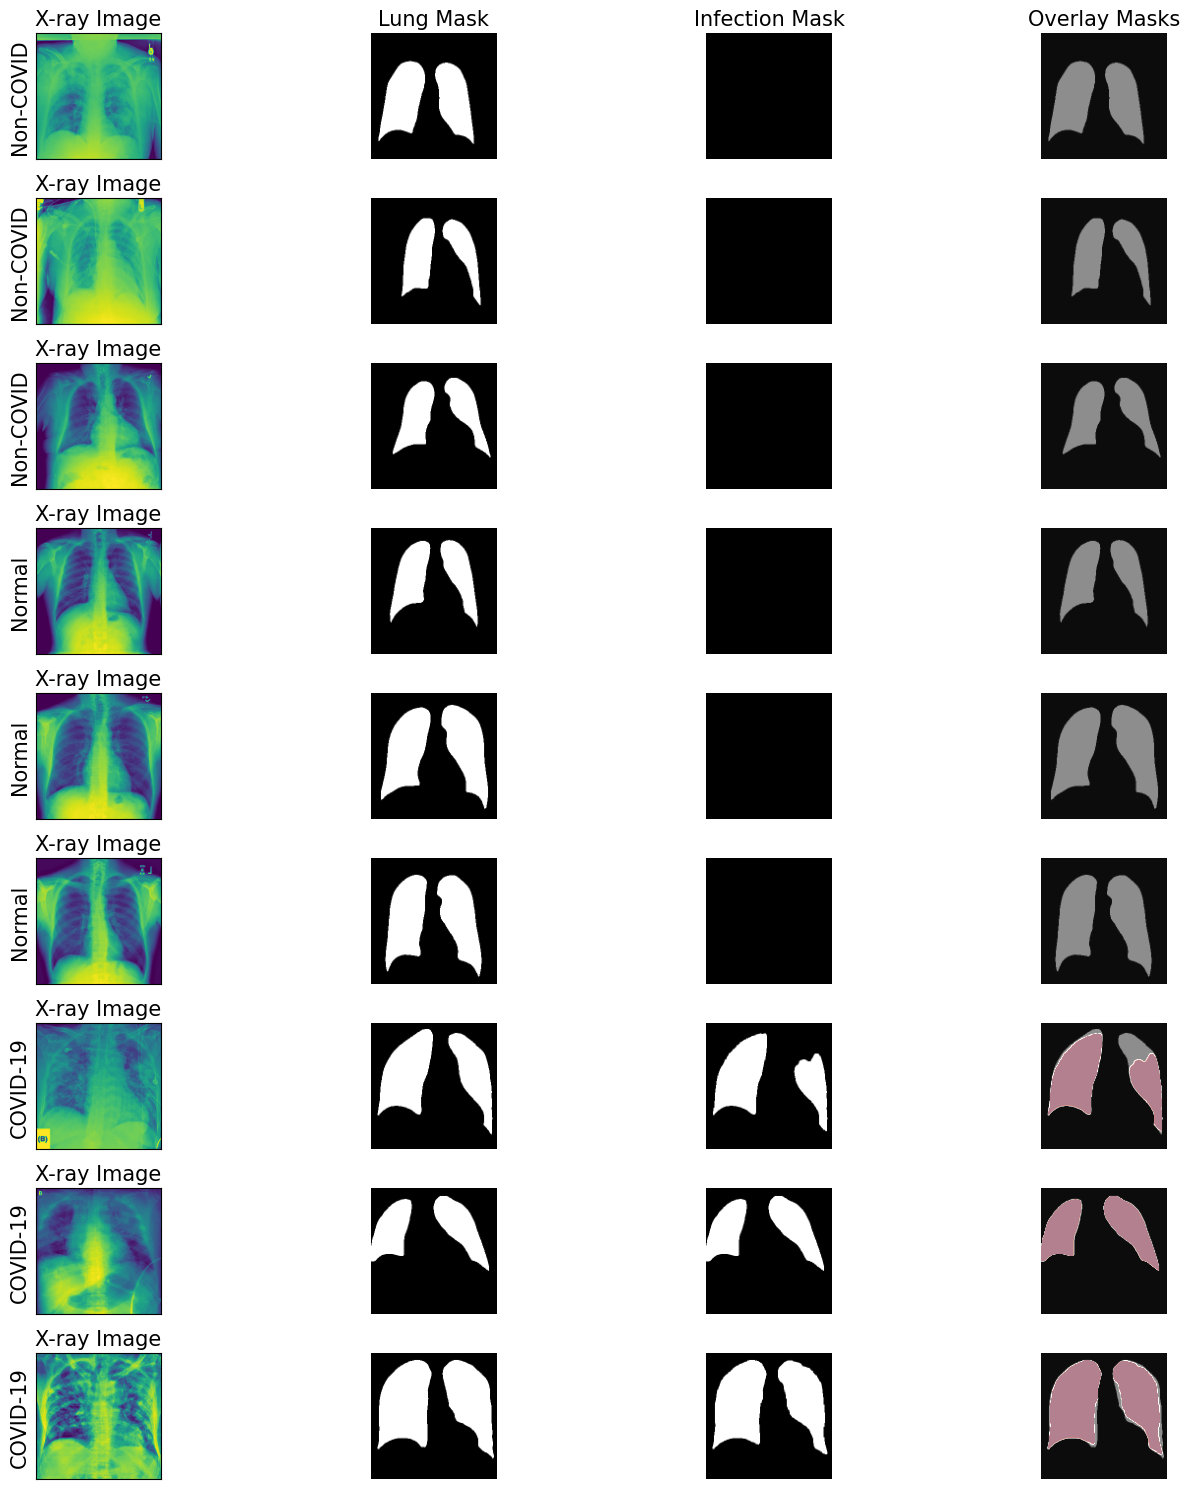

In [31]:
plot(train_df)

# Data Loading

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
class LungDataset(Dataset):
    def __init__(self, df, transform=None, augmentations=None):
        self.transform = transform
        self.augmentations = augmentations
        
        self.images = df.Images.tolist()
        self.masks = df['Infection Masks'].tolist()
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # Open images and masks
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        
        return image, mask

In [6]:
def transform(image, mask):
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor()
    ])
    
    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=PATCH_SIZE, antialias=False)
    ])
    
    return image_transform(image), mask_transform(mask).type(torch.int)

In [36]:
PATCH_SIZE = (128, 128)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

train_dataset = LungDataset(train_df, transform=transform, augmentations=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataset = LungDataset(val_df, transform=transform, augmentations=None)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = LungDataset(test_df, transform=transform, augmentations=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Model 

UNet Components: Up, DoubleConv, OutConv

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

UNet Model 

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128, dropout_rate=dropout_rate))
        self.down2 = (Down(128, 256, dropout_rate=dropout_rate))
        self.down3 = (Down(256, 512, dropout_rate=dropout_rate))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor, dropout_rate=dropout_rate))
        self.up1 = (Up(1024, 512 // factor, bilinear, dropout_rate=dropout_rate))
        self.up2 = (Up(512, 256 // factor, bilinear, dropout_rate=dropout_rate))
        self.up3 = (Up(256, 128 // factor, bilinear, dropout_rate=dropout_rate))
        self.up4 = (Up(128, 64, bilinear, dropout_rate=dropout_rate))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Instantiate Model

In [39]:
# the network deconvolution instead of bilinear upsampling
unet = UNet(1, 2, bilinear=False, dropout_rate=0.1).to(DEVICE)
# unet = nn.DataParallel(unet)
# unet.load_state_dict(torch.load("/kaggle/input/hichic/best_model (1).pth"))

Train 

In [40]:
try:
    import segmentation_models_pytorch as smp
except ImportError:
    !pip install segmentation-models-pytorch -q > /dev/null
    import segmentation_models_pytorch as smp

In [41]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 10
NUM_EPOCHS = 50

# Define the loss function, optimizer, and learning rate scheduler
criterion = smp.losses.DiceLoss('multiclass')
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

In [42]:
from tqdm import tqdm
from torch.nn.parallel import DataParallel

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []

    model = DataParallel(model)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
train_losses, val_losses = train_model(unet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

# Load the best model after training
unet = nn.DataParallel(unet) # this is necessary to get matching key dicts
unet.load_state_dict(torch.load('best_model.pth'))

100%|██████████| 233/233 [00:27<00:00,  8.37it/s]


Epoch [1/50], Train Loss: 0.3399, Validation Loss: 0.2914


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [2/50], Train Loss: 0.2743, Validation Loss: 0.2637


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [3/50], Train Loss: 0.2485, Validation Loss: 0.2623


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [4/50], Train Loss: 0.2263, Validation Loss: 0.2664


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [5/50], Train Loss: 0.2121, Validation Loss: 0.2318


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [6/50], Train Loss: 0.1977, Validation Loss: 0.2024


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [7/50], Train Loss: 0.1920, Validation Loss: 0.1791


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [8/50], Train Loss: 0.1825, Validation Loss: 0.2263


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [9/50], Train Loss: 0.1681, Validation Loss: 0.1654


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [10/50], Train Loss: 0.1647, Validation Loss: 0.1868


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [11/50], Train Loss: 0.1691, Validation Loss: 0.2080


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [12/50], Train Loss: 0.1594, Validation Loss: 0.2001


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [13/50], Train Loss: 0.1388, Validation Loss: 0.1514


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [14/50], Train Loss: 0.1384, Validation Loss: 0.1523


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [15/50], Train Loss: 0.1315, Validation Loss: 0.1537


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [16/50], Train Loss: 0.1265, Validation Loss: 0.1824


100%|██████████| 233/233 [00:27<00:00,  8.54it/s]


Epoch [17/50], Train Loss: 0.1221, Validation Loss: 0.1295


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [18/50], Train Loss: 0.1159, Validation Loss: 0.1692


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [19/50], Train Loss: 0.1170, Validation Loss: 0.1330


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [20/50], Train Loss: 0.1127, Validation Loss: 0.1253


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [21/50], Train Loss: 0.1104, Validation Loss: 0.1493


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [22/50], Train Loss: 0.1102, Validation Loss: 0.1257


100%|██████████| 233/233 [00:27<00:00,  8.51it/s]


Epoch [23/50], Train Loss: 0.1070, Validation Loss: 0.1281


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [24/50], Train Loss: 0.1011, Validation Loss: 0.1282


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [25/50], Train Loss: 0.0999, Validation Loss: 0.1266


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [26/50], Train Loss: 0.0995, Validation Loss: 0.1248


100%|██████████| 233/233 [00:27<00:00,  8.49it/s]


Epoch [27/50], Train Loss: 0.0965, Validation Loss: 0.1347


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [28/50], Train Loss: 0.0971, Validation Loss: 0.1310


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [29/50], Train Loss: 0.0950, Validation Loss: 0.1356


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [30/50], Train Loss: 0.0923, Validation Loss: 0.1232


100%|██████████| 233/233 [00:27<00:00,  8.51it/s]


Epoch [31/50], Train Loss: 0.0870, Validation Loss: 0.1303


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [32/50], Train Loss: 0.0882, Validation Loss: 0.1248


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [33/50], Train Loss: 0.0888, Validation Loss: 0.1269


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [34/50], Train Loss: 0.0872, Validation Loss: 0.1239


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [35/50], Train Loss: 0.0850, Validation Loss: 0.1297


100%|██████████| 233/233 [00:27<00:00,  8.54it/s]


Epoch [36/50], Train Loss: 0.0830, Validation Loss: 0.1264


100%|██████████| 233/233 [00:27<00:00,  8.54it/s]


Epoch [37/50], Train Loss: 0.0837, Validation Loss: 0.1310


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [38/50], Train Loss: 0.0838, Validation Loss: 0.1344


100%|██████████| 233/233 [00:27<00:00,  8.53it/s]


Epoch [39/50], Train Loss: 0.0836, Validation Loss: 0.1309


100%|██████████| 233/233 [00:27<00:00,  8.52it/s]


Epoch [40/50], Train Loss: 0.0827, Validation Loss: 0.1257
Early stopping after 10 epochs without improvement.


<All keys matched successfully>

Evaluate

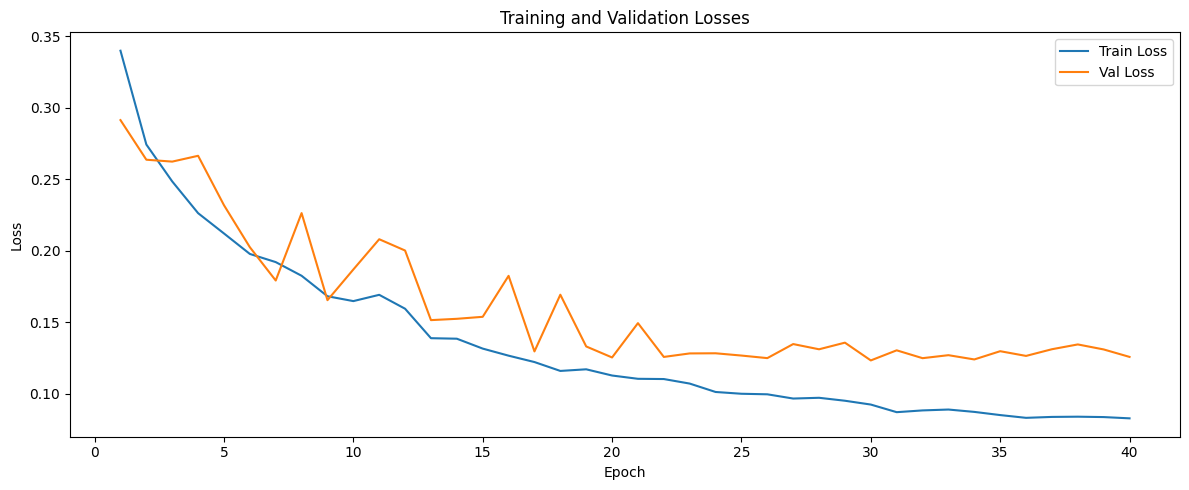

In [48]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics():
    num_epochs = len(train_losses)
    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics()

In [9]:
unet = UNet(1, 2, bilinear=False, dropout_rate=0.1)
unet = nn.DataParallel(unet)
unet.load_state_dict(torch.load("/kaggle/input/best-weights/best_model (2).pth"))

<All keys matched successfully>

In [14]:
BATCH_SIZE = 16
PATCH_SIZE = (128,128)
test_df = pd.read_csv("/kaggle/input/ouput/test_df.csv")
test_dataset = LungDataset(test_df, transform=transform, augmentations=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [23]:
test_dataset

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    confusion = np.zeros((2,2))
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy().ravel()
        pred_masks_np = pred_masks.cpu().detach().numpy().ravel()
        
        confusion += confusion_matrix(true_masks_np, pred_masks_np)
    
    # Calculate metrics
    TN, FP, FN, TP = confusion.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    jaccard_index = TP / (TP + FP + FN)

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard_index:.4f}")
    print(f"  F1 Score : {f1_score:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Ensure DEVICE variable is defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(unet, test_loader)


Metrics for Validation Set:


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


  Accuracy : 0.9720
  IoU      : 0.6445
  F1 Score : 0.7838
  Precision: 0.8040
  Recall   : 0.7646

Metrics for Test Set:


100%|██████████| 73/73 [00:08<00:00,  8.83it/s]

  Accuracy : 0.9728
  IoU      : 0.6558
  F1 Score : 0.7921
  Precision: 0.8061
  Recall   : 0.7786


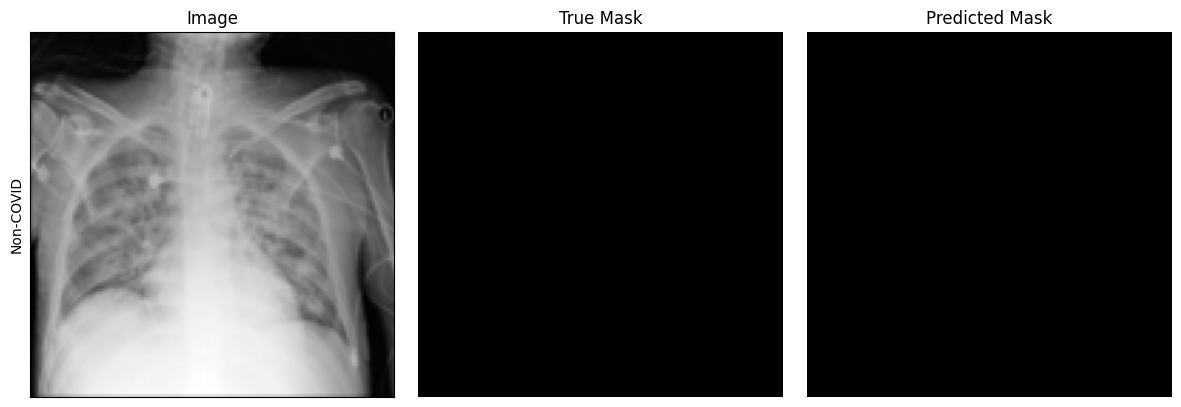

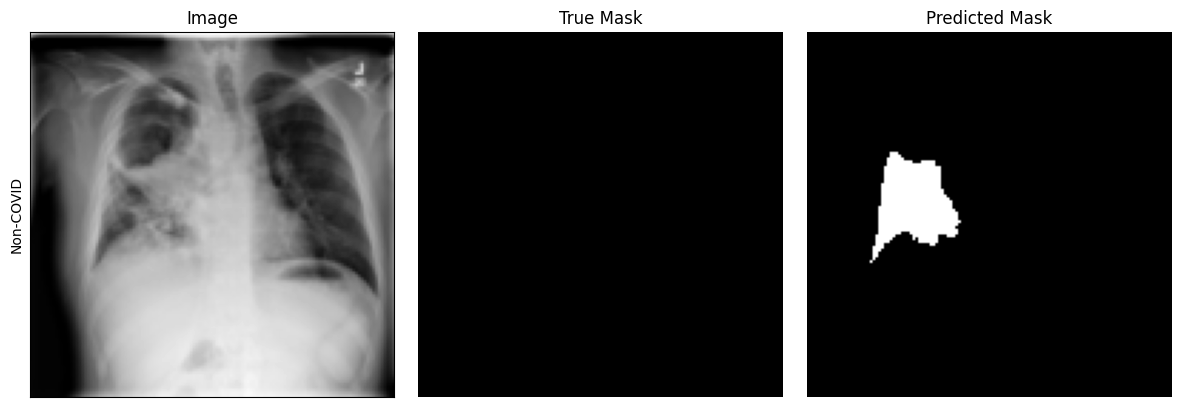

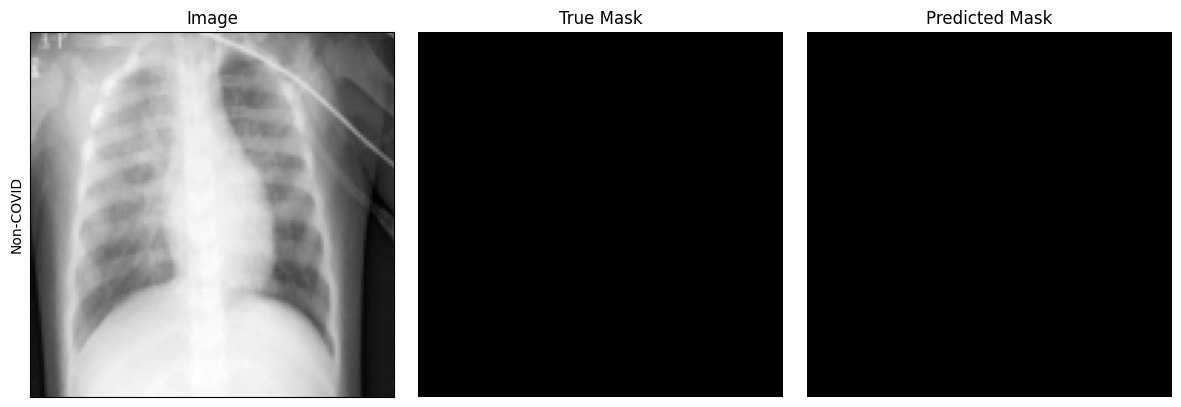

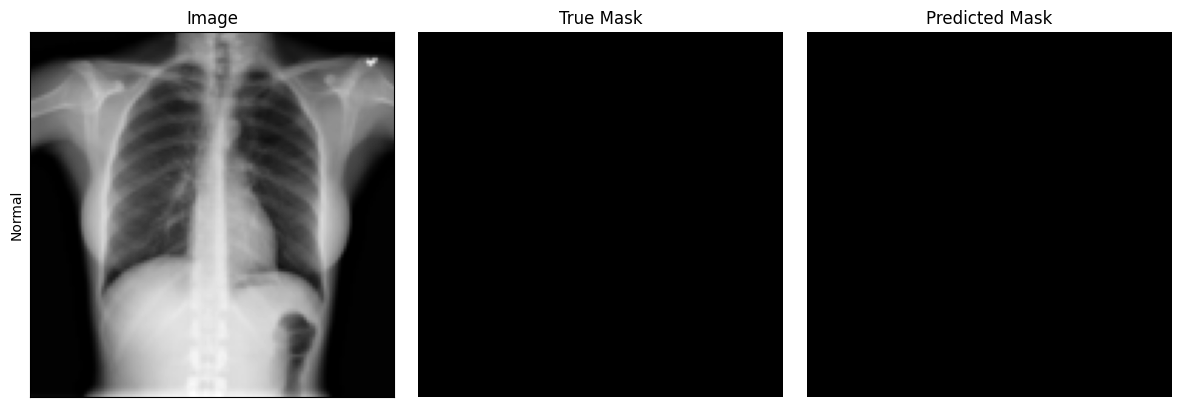

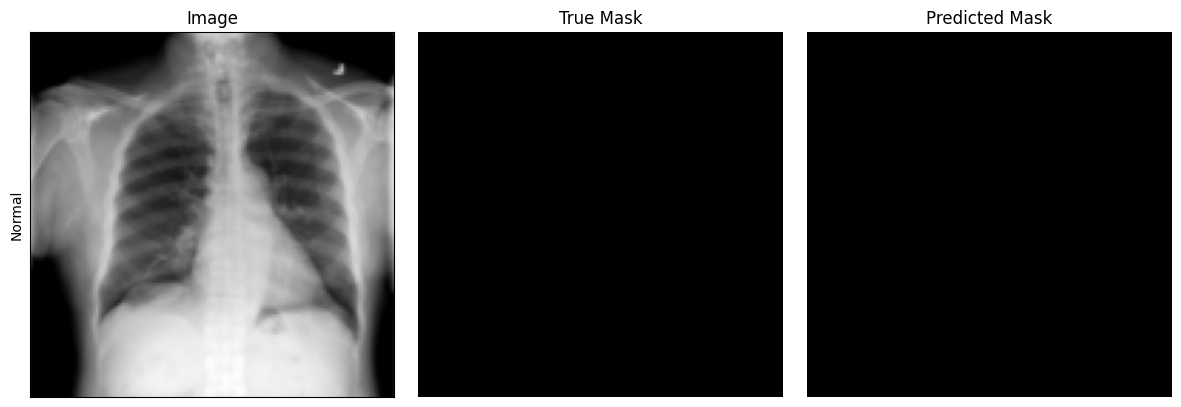

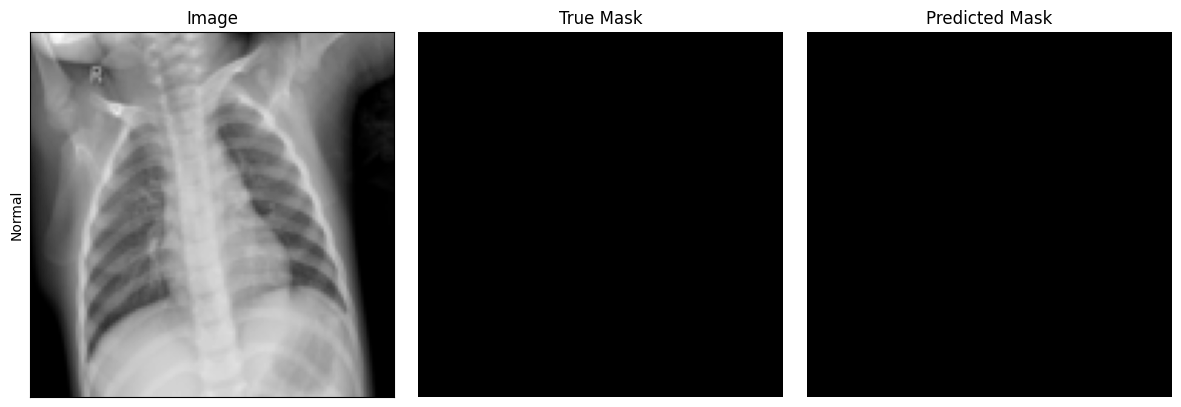

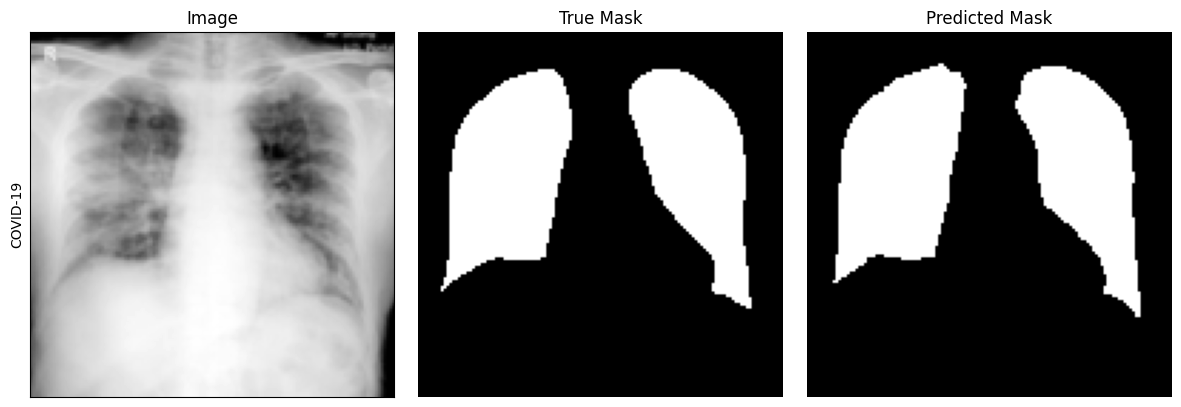

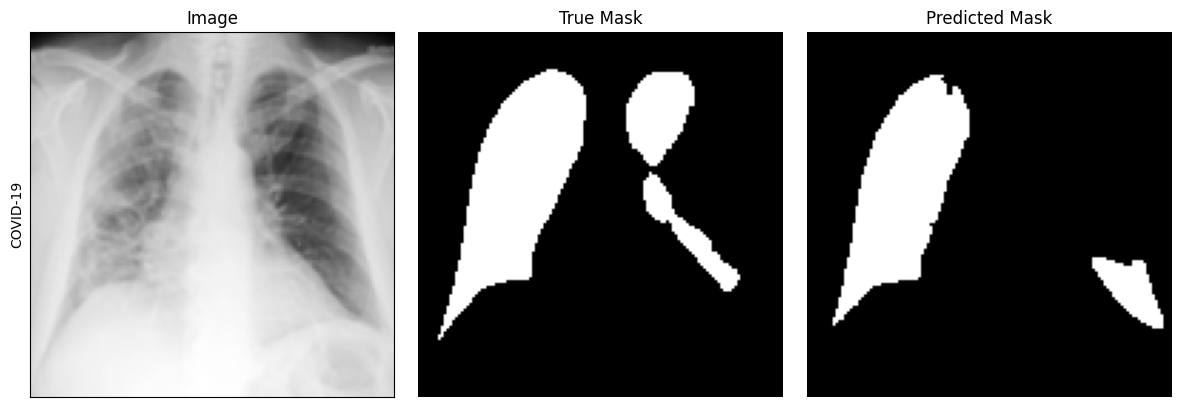

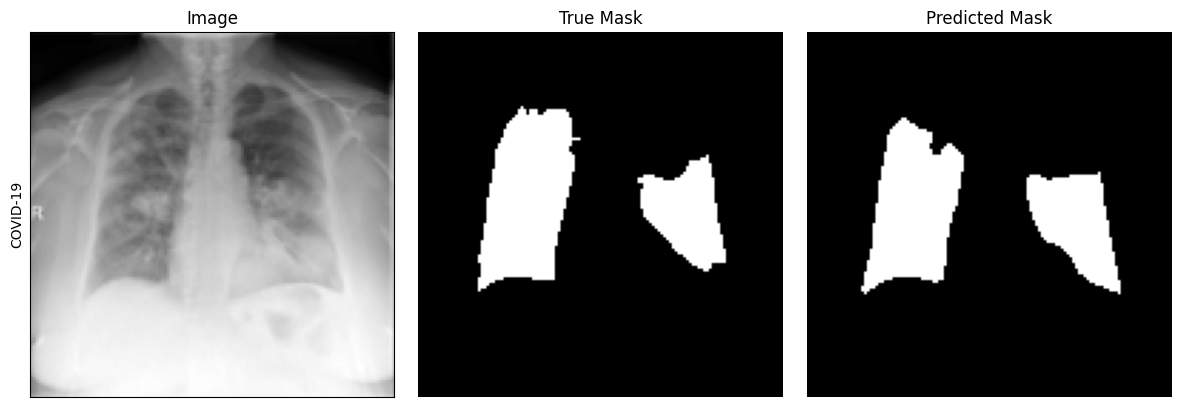

In [28]:
# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()

    indices = []
    labels = []
    for label in test_df.Labels.unique(): 
        indices.extend(test_df.index[test_df.Labels == label][:3].tolist())
        labels.append(label)
        labels.append(label)
        labels.append(label)
    
    for i in range(len(indices)):
        image, mask = dataset[indices[i]]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1,2,0), cmap='gray')
        plt.ylabel(labels[i])
        plt.xticks([])
        plt.yticks([])
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Plot examples from the test dataloader
plot_examples(unet, test_dataset)